## Farm Predict Replication, Grid Search with k-Fold CV
```Michael Yeung, UROP2100F, Apr 2022```

### Setup

In [1]:
#!conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch -y

In [2]:
# set paths for input (retrieve raw data) and output (store intermediate and final results)
DATA_PATH = './data/'; OUTPUT_PATH = './output/'

In [3]:
from IPython.display import clear_output

In [4]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt
import datetime as dt; from collections import Counter; import torch; import re; import sys
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from scipy.linalg import svd; from scipy.stats import pearsonr, spearmanr
import warnings; warnings.filterwarnings("ignore")
print('** DEVICE **')
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.'); device = torch.device("cpu")
print('\n** PATHS **\nInput:\t%s\nOutput:\t%s' % (DATA_PATH, OUTPUT_PATH))

** DEVICE **
There are 7 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090

** PATHS **
Input:	./data/
Output:	./output/


### Helper Functions

In [5]:
# remove non-AV (adj. & v.) string elements of list input
def filter_av(words):
    av_words = []
    for s in words:
        pos = str(re.findall(r'[A-z]+', s))[2:-2]
        if pos in ['a','v']:
            av_words.append(s)
    return av_words

In [6]:
# given data (in DataFrame), return a DataFrame with frequencies (counts) of all words
def get_counts(data_):
    words_freq = Counter(data_.jieba_content.map(set).map(list).sum())
    words_freq_df = pd.DataFrame.from_dict(words_freq, orient='index').reset_index()
    words_freq_df = words_freq_df\
    .rename(columns={words_freq_df.columns[0]:'word',words_freq_df.columns[1]:'freq'})\
    .sort_values(by='freq',ascending=False).reset_index()
    return words_freq_df[['word','freq']]

In [7]:
# given (i) a list** of word strings, (ii) a list of "frequent" words
# return a list** of integers (features) of "frequent" words' frequencies
def featurize(words,freq_words):
    c = Counter(words)
    return [int(c[w]) for w in freq_words]

In [8]:
# given a list of tuples of 2 elements (real part and imaginary part),
# return the real part if imaginary part is 0, else return 0
def extract_real(cplx):
    real_part = []
    for e in cplx:
        if e[1] != 0:
            real_part.append(0)
        else:
            real_part.append(e[0])
    return torch.tensor(real_part).type(torch.float32)

### Grid Search Functions

In [47]:
def farmPredictGridSearch_kFoldCV(training_data,k=5,serial='_',skip_folds=None):
    kf = KFold(n_splits=k,shuffle=True,random_state=1)
    for fold, (train2_index, valid_index) in enumerate(kf.split(training_data.index)):
        if skip_folds is not None:
            if fold in skip_folds: continue
        print('*** Fold {} ***'.format(fold))
        summary_df,train2_ys,valid_ys\
        = farmPredictGridSearch(training_data.iloc[train2_index],\
                                training_data.iloc[valid_index],\
                                current_fold=fold)
        summary_df.to_parquet(OUTPUT_PATH+'farm_gs_{}_summary_fold-{}.parquet.gzip'.format(serial,fold))
        train2_ys.to_parquet(OUTPUT_PATH+'farm_gs_{}_train2_ys_fold-{}.parquet.gzip'.format(serial,fold))
        valid_ys.to_parquet(OUTPUT_PATH+'farm_gs_{}_valid_ys_fold-{}.parquet.gzip'.format(serial,fold))
        print('Fold {} complete. Files exported to {}'.format(fold,OUTPUT_PATH))
    return

#### Note: Set Hyperparameters Grid and Cuda (GPU) Settings here

In [48]:
def farmPredictGridSearch(data_train2_original, data_valid_original,current_fold=None):

    # store tensors on 1 (or 2) GPU devices (to aviod lack of memory)
    DEVICE_1 = 'cuda:5'
    DEVICE_2 = 'cuda:0'
    
    # HYPER-PARAMETERS
    HYPER_NUM_FEATURES = [500,1000,5000] # number of AV words used
    HYPER_EIGENVAL_PCT = [0.01,0.05,0.1] # fraction of eigenvalues used
    HYPER_IDO_MIN_CORR = [0.0005,0.001,0.005] # min. corr. between idosyncratic components & label
    HYPER_LASSO_LAMBDA = [0,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005] # lambda of the LASSO regression
    
    # get frequencies of words
    counts_df = get_counts(data_train2_original)
    
    columns = ['FOLD','HYPER_N','HYPER_E','HYPER_I','HYPER_L','VAR_EXP','LEN_IDO',\
               'TRN_P','TRN_S','TRN_RMSE','VAL_P','VAL_S','VAL_RMSE']

    print('{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}'.format(*columns))

    train2_ys = pd.DataFrame(data_train2_original['specret_2d'])
    valid_ys = pd.DataFrame(data_valid_original['specret_2d'])
    summary_df = pd.DataFrame(columns=columns)

    for NUM_FEATURES in HYPER_NUM_FEATURES:

        # featurize jieba content on a copied dataframe
        data_train2 = data_train2_original.copy(); data_valid = data_valid_original.copy()
        words_used = list(counts_df[:NUM_FEATURES]['word'])
        data_train2['jieba_content'] = data_train2.jieba_content.map(lambda x: featurize(x, words_used))
        data_valid['jieba_content'] = data_valid.jieba_content.map(lambda x: featurize(x, words_used))

        # prepare tensors on GPU
        X_train = torch.tensor(np.stack(data_train2.jieba_content.values)).type(torch.float32).cuda(device=DEVICE_1)
        y_train = torch.tensor(np.array(data_train2.specret_2d)).type(torch.float32).cuda(device=DEVICE_1)
        X_valid = torch.tensor(np.stack(data_valid.jieba_content.values)).type(torch.float32).cuda(device=DEVICE_2)
        y_valid = torch.tensor(np.array(data_valid.specret_2d)).type(torch.float32).cuda(device=DEVICE_2)

        # compute eigens of XTX
        eigenvals_xtx, eigenvecs_xtx = torch.eig((X_train.T@X_train).cpu(), eigenvectors=True)

        for EIGENVAL_PCT in HYPER_EIGENVAL_PCT:
            num_eigenval = int(NUM_FEATURES*(EIGENVAL_PCT))

            # extract largest k real eigenvalues and their eigenvectors (of XXT)
            eigenvals_real = extract_real(eigenvals_xtx)
            eigenvals_df = pd.Series(eigenvals_real).sort_values(ascending=False)
            variance_explained = eigenvals_df[:num_eigenval].sum()/eigenvals_df.sum()
            eigenvals_topk = torch.topk(eigenvals_real,num_eigenval).indices
            XV = torch.nn.functional.normalize((X_train@eigenvecs_xtx.cuda(device=DEVICE_1)).T,p=2).T[:,eigenvals_topk]

            # compute/construct F_hat, B_hat, U_hat, BTB, and BTB inverse
            F_hat = XV*(X_train.shape[0])**0.5
            B_hat = X_train.T@F_hat.cuda(device=DEVICE_1)/(X_train.shape[0])
            U_hat = X_train - F_hat@B_hat.T
            BTB = torch.tensor(np.diag(torch.topk(extract_real(eigenvals_xtx),num_eigenval).values))/len(X_train)
            BTB_inv = torch.linalg.inv(BTB).cuda(device=DEVICE_1)

            # compute f_new and u_new for train2 and valid data
            f_new_train = (BTB_inv@B_hat.T)@X_train.T.type(torch.float32)
            f_new_valid = (BTB_inv.cuda(device=DEVICE_2)@B_hat.cuda(device=DEVICE_2).T)@X_valid.T.type(torch.float32)
            u_new_train = X_train.T - B_hat@f_new_train
            u_new_valid = X_valid.T - B_hat.cuda(device=DEVICE_2)@f_new_valid.cuda(device=DEVICE_2)

            # OLS regression
            reg1 = LinearRegression().fit(F_hat.cpu(), y_train.cpu())
            y_hat = reg1.predict(F_hat.cpu())
            a_hat = reg1.intercept_; b_hat = torch.tensor(reg1.coef_).cuda(device=DEVICE_1)
            y_residual = y_train - torch.tensor(y_hat).cuda(device=DEVICE_1)

            # correlation between U_hat and label
            corrs = [pearsonr(U_hat.T[j].cpu(), y_train.cpu())[0] for j in range(len(U_hat.T))]
            corrs = [0 if x != x else abs(x) for x in corrs]

            # find the idiosyncratic components satisfying minimum correlation
            for IDO_MIN_CORR in HYPER_IDO_MIN_CORR:
                df = pd.DataFrame(corrs,columns=['corr'])
                df['isCharged'] = df['corr'].map(lambda x: abs(x)>IDO_MIN_CORR)
                charged_index = list(df[df.isCharged].index)
                U_hat_S_hat = U_hat.T[charged_index].T

                # LASSO regression
                for LASSO_LAMBDA in HYPER_LASSO_LAMBDA:
                    reg2 = Lasso(alpha=LASSO_LAMBDA)
                    reg2.fit(U_hat_S_hat.cpu(),y_residual.cpu())
                    beta_hat = torch.tensor(reg2.coef_).cuda(device=DEVICE_1)
                    beta_nonzero_len = torch.count_nonzero(beta_hat)

                    # validation
                    y_pred_train = a_hat + b_hat@f_new_train \
                    + beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]
                    y_pred_valid = a_hat + b_hat.cuda(device=DEVICE_2)@f_new_valid \
                    + beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_valid.type(torch.float32)[charged_index]

                    # store results
                    SPECS = (NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA)
                    identifier = 'farm_n{}_e{}_i{}_l{}'.format(*SPECS)
                    y_pred_train_series = pd.Series(y_pred_train.cpu(),name=identifier,index=train2_ys.index)
                    y_pred_valid_series = pd.Series(y_pred_valid.cpu(),name=identifier,index=valid_ys.index)

                    # two variables storing y_pred's
                    train2_ys = pd.concat([train2_ys,y_pred_train_series],axis=1) # all predicted sentiment (train)
                    valid_ys = pd.concat([valid_ys,y_pred_valid_series],axis=1) # all predicted sentiment (valid)

                    train_pearson = round(pearsonr(train2_ys['specret_2d'],train2_ys[identifier])[0],6)
                    train_spearman = round(spearmanr(train2_ys['specret_2d'],train2_ys[identifier])[0],6)
                    train_rmse = round((((train2_ys['specret_2d'] - train2_ys[identifier])**2).mean())**0.5,6)

                    valid_pearson = round(pearsonr(valid_ys['specret_2d'],valid_ys[identifier])[0],6)
                    valid_spearman = round(spearmanr(valid_ys['specret_2d'],valid_ys[identifier])[0],6)
                    valid_rmse = round((((valid_ys['specret_2d'] - valid_ys[identifier])**2).mean())**0.5,6)

                    stats = (float(str(variance_explained)[:6]),str(int(beta_nonzero_len))+'/'+str(len(charged_index)))
                    performance = (train_pearson,train_spearman,train_rmse,valid_pearson,valid_spearman,valid_rmse)
                    print('{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}{:>9}'\
                          .format(current_fold,*SPECS,*stats,*performance))

                    # summary_df storing correlations and rmse
                    new_row = pd.DataFrame([[current_fold,*SPECS,*stats,*performance]],columns=columns)
                    summary_df = pd.concat([summary_df,new_row],ignore_index=True)
                    
    # manually release GPU memory (may not work)
    del X_train, y_train, X_valid, y_valid, XV, F_hat, B_hat, U_hat, BTB, BTB_inv
    del f_new_train, f_new_valid, u_new_train, u_new_valid
    return summary_df, train2_ys, valid_ys

## Main

### Preprocessing

In [11]:
data = pd.read_parquet(DATA_PATH+'preprocessed_data_1.parquet.gzip')
data.date = data.date.map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
data['jieba_content'] = data.jieba_content.map(filter_av)
data_train = data.loc[data.date<dt.datetime(2015,1,1)]
data_test = data.loc[data.date>=dt.datetime(2015,1,1)]
data_train.shape, data_test.shape

((180353, 7), (292340, 7))

### k-Fold CV GS

Note: If the GPU memory cannot be released, restart the kernal after every fold.<br>
Skip previous fold(s), e.g. to resume from fold ```m```, ```skip_folds=[0,1,2,...,m-1]```

In [12]:
# the results df is exported continuingly and can be monitored
# args: training data, num folds, serial (a name for this CV, used for naming files)
# use skip_folds to RESUME partially done CV (set the kwarg to skip some folds already done, in a list of int)
# When starting a CV for all folds, set kwarg skip_folds to None (or remove the kwarg)
%time farmPredictGridSearch_kFoldCV(data_train.copy(),k=5,serial='20220420_full',\
                                    skip_folds=[0,1,2,3]) # RESUME a partially done CV
#FOLD  HYPER_N  HYPER_E  HYPER_I  HYPER_L  VAR_EXP  LEN_IDO    TRN_P    TRN_S TRN_RMSE    VAL_P    VAL_S VAL_RMSE

*** Fold 4 ***
     FOLD  HYPER_N  HYPER_E  HYPER_I  HYPER_L  VAR_EXP  LEN_IDO    TRN_P    TRN_S TRN_RMSE    VAL_P    VAL_S VAL_RMSE
        4      500     0.01   0.0005        0   0.4821  438/438 0.121757 0.140462 0.108803 0.150607 0.140265 0.042131
        4      500     0.01   0.0005    5e-06   0.4821  415/438 0.121698 0.141097 0.108804 0.151462 0.141174 0.042095
        4      500     0.01   0.0005    1e-05   0.4821  396/438 0.121569  0.14172 0.108806 0.152199 0.141991 0.042061
        4      500     0.01   0.0005    5e-05   0.4821  255/438 0.118926  0.14438 0.108845 0.155649 0.146597 0.041879
        4      500     0.01   0.0005   0.0001   0.4821  155/438 0.114897 0.145156   0.1089 0.156232 0.148849 0.041778
        4      500     0.01   0.0005   0.0005   0.4821   36/438 0.097015  0.14585 0.109118 0.152517 0.150696 0.041596
        4      500     0.01   0.0005    0.001   0.4821   20/438 0.086605  0.13949 0.109228 0.142167 0.142287 0.041619
        4      500     0.01   0.0005    0

### Interpret k-Fold CV GS Results

In [13]:
serial = '20220420_full'
num_folds = 5

cv_results = pd.read_parquet(OUTPUT_PATH+'farm_gs_{}_summary_fold-0.parquet.gzip'.format(serial))
for fold in range(1,num_folds):
    cv_results = pd.concat([cv_results,pd.read_parquet(OUTPUT_PATH+'farm_gs_{}_summary_fold-{}.parquet.gzip'\
                                                       .format(serial,fold))],axis=0)
cv_results

,FOLD,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
0,0,500,0.01,0.0005,0.000000,0.4830,452/452,0.133280,0.165120,0.076133,0.082767,0.157849,0.161417
1,0,500,0.01,0.0005,0.000005,0.4830,424/452,0.133122,0.165614,0.076135,0.082894,0.159433,0.161419
2,0,500,0.01,0.0005,0.000010,0.4830,397/452,0.132892,0.165922,0.076138,0.082876,0.160500,0.161422
3,0,500,0.01,0.0005,0.000050,0.4830,218/452,0.129005,0.165494,0.076181,0.082497,0.166027,0.161444
4,0,500,0.01,0.0005,0.000100,0.4830,135/452,0.123722,0.164344,0.076235,0.082610,0.166394,0.161461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,4,5000,0.10,0.0050,0.000050,0.9139,76/140,0.224973,0.134297,0.106903,0.128159,0.134639,0.043991
212,4,5000,0.10,0.0050,0.000100,0.9139,46/140,0.188303,0.142577,0.107723,0.145807,0.142227,0.042767
213,4,5000,0.10,0.0050,0.000500,0.9139,1/140,0.126822,0.145712,0.108735,0.159560,0.143046,0.041985
214,4,5000,0.10,0.0050,0.001000,0.9139,0/140,0.120763,0.145474,0.108816,0.159292,0.142479,0.041985


In [14]:
cv_results_folds_mean = cv_results.groupby(by=['HYPER_N','HYPER_E','HYPER_I','HYPER_L'])\
[['TRN_P','TRN_S','VAL_P','VAL_S','TRN_RMSE','VAL_RMSE','VAR_EXP']].mean().reset_index()
cv_results_folds_mean.sort_values(by='VAL_S',ascending=False).head()

,HYPER_N,HYPER_E,HYPER_I,HYPER_L,TRN_P,TRN_S,VAL_P,VAL_S,TRN_RMSE,VAL_RMSE,VAR_EXP
141,1000,0.1,0.0050,0.0005,0.105246,0.155416,0.117879,0.154190,0.098559,0.088659,0.7832
125,1000,0.1,0.0005,0.0005,0.105246,0.155416,0.117879,0.154190,0.098559,0.088659,0.7832
133,1000,0.1,0.0010,0.0005,0.105246,0.155416,0.117879,0.154190,0.098559,0.088659,0.7832
142,1000,0.1,0.0050,0.0010,0.102740,0.155120,0.118383,0.153911,0.098585,0.088643,0.7832
134,1000,0.1,0.0010,0.0010,0.102740,0.155120,0.118383,0.153911,0.098585,0.088643,0.7832


In [27]:
cv_results.loc[cv_results.index==133]

,FOLD,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
133,0,1000,0.1,0.001,0.0005,0.7831,1/692,0.112972,0.162995,0.076327,0.075872,0.165009,0.161519
133,1,1000,0.1,0.001,0.0005,0.7834,3/651,0.105769,0.155644,0.100030,0.090425,0.145723,0.096334
133,2,1000,0.1,0.001,0.0005,0.7832,3/638,0.101617,0.151506,0.109195,0.166012,0.147733,0.040141
133,3,1000,0.1,0.001,0.0005,0.7835,2/668,0.104614,0.156157,0.098185,0.092419,0.159064,0.103689
133,4,1000,0.1,0.001,0.0005,0.7828,4/653,0.101258,0.150778,0.109056,0.164666,0.153419,0.041612


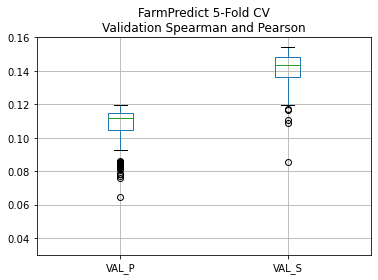

In [49]:
cv_results_folds_mean[['VAL_P','VAL_S']].boxplot()
plt.title('FarmPredict 5-Fold CV\nValidation Spearman and Pearson')
plt.ylim(0.03,0.16); plt.show()

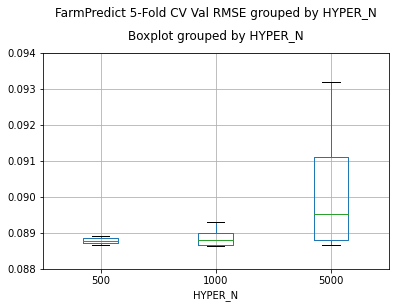

In [54]:
cv_results_folds_mean.boxplot(column='VAL_RMSE',by='HYPER_N',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val RMSE grouped by HYPER_N\n\n')
plt.ylim(0.088,0.094); plt.show()

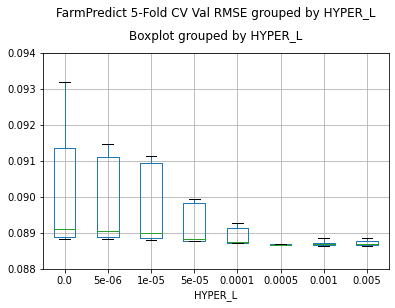

In [55]:
# regularization reduce estimator variance
cv_results_folds_mean.boxplot(column='VAL_RMSE',by='HYPER_L',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val RMSE grouped by HYPER_L\n\n')
plt.ylim(0.088,0.094); plt.show()

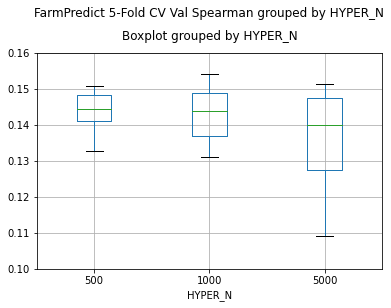

In [56]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_N',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val Spearman grouped by HYPER_N\n\n')
plt.ylim(0.10,0.16); plt.show()

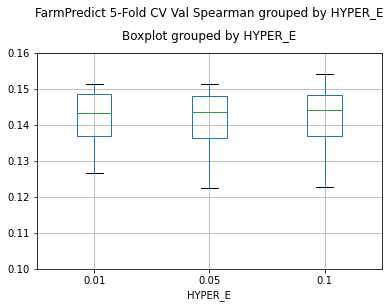

In [57]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_E',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val Spearman grouped by HYPER_E\n\n')
plt.ylim(0.10,0.16); plt.show()

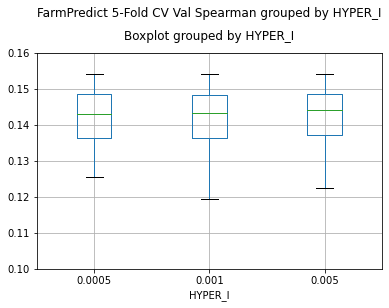

In [58]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_I',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val Spearman grouped by HYPER_I\n\n')
plt.ylim(0.10,0.16); plt.show()

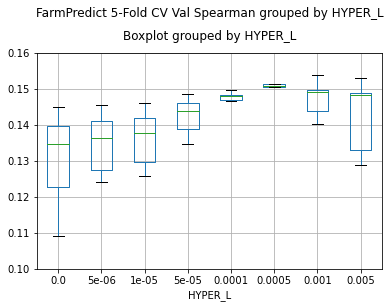

In [59]:
cv_results_folds_mean.boxplot(column='VAL_S',by='HYPER_L',showfliers=False)
plt.title('FarmPredict 5-Fold CV Val Spearman grouped by HYPER_L\n\n')
plt.ylim(0.10,0.16); plt.show()

### Testing

In [28]:
NUM_FEATURES = 1000
EIGENVAL_PCT = 0.1
IDO_MIN_CORR = 0.001
LASSO_LAMBDA = 0.0005

In [29]:
# store tensors on 1 (or 2) GPU devices (to aviod lack of memory)
DEVICE_1 = 'cuda:2'
DEVICE_2 = 'cuda:2'

columns = ['HYPER_N','HYPER_E','HYPER_I','HYPER_L','VAR_EXP','LEN_IDO',\
           'TRN_P','TRN_S','TRN_RMSE','VAL_P','VAL_S','VAL_RMSE']

print('Start Testing with Hyperparamters:\n{}\t{}\t{}\t{}'\
      .format(NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA))

# featurize jieba content on a copied dataframe
data_train_t = data_train.copy(); data_test_t = data_test.copy()
counts_df_testing = get_counts(data_train_t)
words_used = list(counts_df_testing[:NUM_FEATURES]['word'])
print('Get Counts Done.')

data_train_t['jieba_content'] = data_train_t.jieba_content.map(lambda x: featurize(x, words_used))
data_test_t['jieba_content'] = data_test_t.jieba_content.map(lambda x: featurize(x, words_used))
print('Featurization Done.')
    
# prepare tensors on GPU
X_train = torch.tensor(np.stack(data_train_t.jieba_content.values)).type(torch.float32).cuda(device=DEVICE_1)
y_train = torch.tensor(np.array(data_train_t.specret_2d)).type(torch.float32).cuda(device=DEVICE_1)
X_test = torch.tensor(np.stack(data_test_t.jieba_content.values)).type(torch.float32).cuda(device=DEVICE_2)
y_test = torch.tensor(np.array(data_test_t.specret_2d)).type(torch.float32).cuda(device=DEVICE_2)
    
# compute eigens of XTX
eigenvals_xtx, eigenvecs_xtx = torch.eig((X_train.T@X_train).cpu(), eigenvectors=True)
num_eigenval = int(NUM_FEATURES*(EIGENVAL_PCT))
        
# extract largest k real eigenvalues and their eigenvectors (of XXT)
eigenvals_real = extract_real(eigenvals_xtx)
eigenvals_df = pd.Series(eigenvals_real).sort_values(ascending=False)
variance_explained = eigenvals_df[:num_eigenval].sum()/eigenvals_df.sum()
eigenvals_topk = torch.topk(eigenvals_real,num_eigenval).indices
XV = torch.nn.functional.normalize((X_train@eigenvecs_xtx.cuda(device=DEVICE_1)).T,p=2).T[:,eigenvals_topk]
print('Eigens Done.')

# compute/construct F_hat, B_hat, U_hat, BTB, and BTB inverse
F_hat = XV*(X_train.shape[0])**0.5
B_hat = X_train.T@F_hat.cuda(device=DEVICE_1)/(X_train.shape[0])
U_hat = X_train - F_hat@B_hat.T
BTB = torch.tensor(np.diag(torch.topk(extract_real(eigenvals_xtx),num_eigenval).values))/len(X_train)
BTB_inv = torch.linalg.inv(BTB).cuda(device=DEVICE_1)

# compute f_new and u_new for train and test data
f_new_train = (BTB_inv@B_hat.T)@X_train.T.type(torch.float32)
f_new_test = (BTB_inv.cuda(device=DEVICE_2)@B_hat.cuda(device=DEVICE_2).T)@X_test.T.type(torch.float32)
u_new_train = X_train.T - B_hat@f_new_train
u_new_test = X_test.T - B_hat.cuda(device=DEVICE_2)@f_new_test.cuda(device=DEVICE_2)
        
# OLS regression
reg1 = LinearRegression().fit(F_hat.cpu(), y_train.cpu())
y_hat = reg1.predict(F_hat.cpu())
a_hat = reg1.intercept_; b_hat = torch.tensor(reg1.coef_).cuda(device=DEVICE_1)
y_residual = y_train - torch.tensor(y_hat).cuda(device=DEVICE_1)
        
# correlation between U_hat and label
corrs = [pearsonr(U_hat.T[j].cpu(), y_train.cpu())[0] for j in range(len(U_hat.T))]
corrs = [0 if x != x else abs(x) for x in corrs]
        
# find the idiosyncratic components satisfying minimum correlation
df = pd.DataFrame(corrs,columns=['corr'])
df['isCharged'] = df['corr'].map(lambda x: abs(x)>IDO_MIN_CORR)
charged_index = list(df[df.isCharged].index)
U_hat_S_hat = U_hat.T[charged_index].T
            
# LASSO regression
reg2 = Lasso(alpha=LASSO_LAMBDA)
reg2.fit(U_hat_S_hat.cpu(),y_residual.cpu())
beta_hat = torch.tensor(reg2.coef_).cuda(device=DEVICE_1)
beta_nonzero_len = torch.count_nonzero(beta_hat)
print('Regressions Done.')

Start Testing with Hyperparamters:
1000	0.1	0.001	0.0005
Get Counts Done.
Featurization Done.
Eigens Done.
Regressions Done.


In [30]:
# testing
y_pred_train = a_hat + b_hat@f_new_train \
+ beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]
y_pred_train_sys = b_hat@f_new_train
y_pred_train_ido = beta_hat.type(torch.float32)@u_new_train.type(torch.float32)[charged_index]

y_pred_test = a_hat + b_hat.cuda(device=DEVICE_2)@f_new_test \
+ beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_test.type(torch.float32)[charged_index]
y_pred_test_sys = b_hat.cuda(device=DEVICE_2)@f_new_test
y_pred_test_ido = beta_hat.type(torch.float32).cuda(device=DEVICE_2)@u_new_test.type(torch.float32)[charged_index]
                
train_pearson = round(pearsonr(y_train.cpu(),y_pred_train.cpu())[0],6)
train_spearman = round(spearmanr(y_train.cpu(),y_pred_train.cpu())[0],6)
train_rmse = round((((np.array(y_train.cpu()) - np.array(y_pred_train.cpu()))**2).mean())**0.5,6)

test_pearson = round(pearsonr(y_test.cpu(),y_pred_test.cpu())[0],6)
test_spearman = round(spearmanr(y_test.cpu(),y_pred_test.cpu())[0],6)
test_rmse = round(float(((np.array(y_test.cpu()) - np.array(y_pred_test.cpu())**2).mean())**0.5),6)

SPECS = (NUM_FEATURES,EIGENVAL_PCT,IDO_MIN_CORR,LASSO_LAMBDA)
stats = (round(variance_explained,6),str(int(beta_nonzero_len))+'/'+str(len(charged_index)))
performance = (train_pearson,train_spearman,train_rmse,test_pearson,test_spearman,test_rmse)
test_summary_df = pd.DataFrame([[*SPECS,*stats,*performance]],columns=columns)
                
clear_output()
test_summary_df

,HYPER_N,HYPER_E,HYPER_I,HYPER_L,VAR_EXP,LEN_IDO,TRN_P,TRN_S,TRN_RMSE,VAL_P,VAL_S,VAL_RMSE
0,1000,0.1,0.001,0.0005,0.783147,1/649,0.10212,0.15622,0.099309,0.099283,0.116008,0.091087


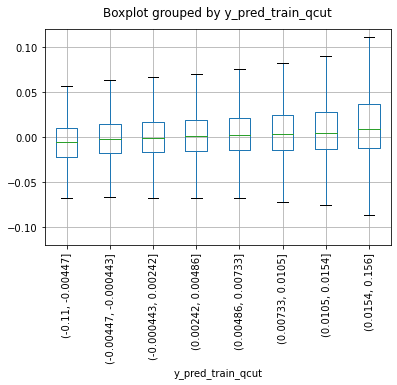

In [71]:
bp_df = pd.DataFrame(np.hstack((np.array(y_train.cpu()).reshape(-1,1),np.array(y_pred_train.cpu()).reshape(-1,1))),\
                     columns=['y_train','y_pred_train'])
bp_df['y_pred_train_qcut'] = pd.qcut(y_pred_train.cpu(),q=8)
bp_df.boxplot(column=['y_train'], by='y_pred_train_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

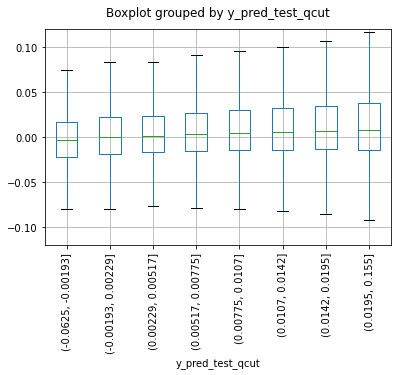

In [61]:
bp_df = pd.DataFrame(np.hstack((np.array(y_test.cpu()).reshape(-1,1),np.array(y_pred_test.cpu()).reshape(-1,1))),\
                     columns=['y_test','y_pred_test'])
bp_df['y_pred_test_qcut'] = pd.qcut(y_pred_test.cpu(),q=8)
bp_df.boxplot(column=['y_test'], by='y_pred_test_qcut', showfliers=False)
plt.ylim(-0.12,0.12)
plt.xticks(rotation=90); plt.title(''); plt.show()

In [62]:
test_results = data_test[['ID','SecuCode','date','specret_2d']]
test_results['y_pred'] = y_pred_test.cpu()
test_results['y_pred_sys'] = y_pred_test_sys.cpu()
test_results['y_pred_ido'] = y_pred_test_ido.cpu()

In [63]:
test_results.head(3)

,ID,SecuCode,date,specret_2d,y_pred,y_pred_sys,y_pred_ido
180353,672010,600315,2015-01-05,0.044812,0.013484,0.008724,-0.000414
180354,672047,600315,2015-01-05,0.044812,0.005509,-0.003976,0.004311
180355,672017,000063,2015-01-05,0.066843,0.008303,0.002951,0.000179


In [64]:
serial

'20220420_full'

In [65]:
test_results.to_parquet(OUTPUT_PATH+'test_results_FarmPredict_GS-tuned_{}.parquet.gzip'.format(serial))

In [67]:
np.array([beta_hat.cpu(),np.array(words_used)[charged_index]])

array([tensor([0.0000, 0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000, -0.0000,
               -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, 0.0000,
               0.0000, -0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
               0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
               -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000,
               -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000, 0.0000,
               0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000, 0.0000, -0.0000,
               0.0000, 0.0000, -0.0000, -0.0000, 0.0000, 0.0000, -0.0000, -0.0000, -0.0000,
               0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000,
               -0.0000, -0.0000, -0.0000, -0.0000, 0.0000, -0.0000, 0.0000, 0.0000, -0.0000,
               0.0000, 0.0000, 0.0000, 0.0000, -0.0000, -0.0000, 0.0000, -0.0000, -0.0000,


In [40]:
beta_df = pd.DataFrame(np.vstack((np.array(beta_hat.cpu()).T,np.array(words_used)[charged_index].T)).T,\
                       columns=['beta','word'])
beta_df['beta'] = beta_df.beta.map(float)
pos_words_df = beta_df.loc[beta_df.beta>0].sort_values(by='beta',ascending=False)
neg_words_df = beta_df.loc[beta_df.beta<0].sort_values(by='beta',ascending=True)
lasso_removed_words_df = beta_df.loc[beta_df.beta==0].sort_values(by='beta',ascending=True)

In [68]:
pos_words_df.head(8)

,beta,word
182,0.005655,承诺v


In [69]:
neg_words_df.head(8)

,beta,word


In [70]:
print(*list(lasso_removed_words_df.word))

增长v 促v 组合v 调v 短a 饱满v 组建v 存v 分为v 延迟v 侵蚀v 搭建v 改进v 抢占v 提振v 延长v 固定a 认识v 举措v 跨v 成v 利息支出v 涵盖v 略降v 供v 包装v 治疗v 注册v 结转v 取决于v 停产v 加v 位居v 接受v 简单a 不错a 减排v 集成v 尚有v 宣布v 回调v 庞大a 调低v 休闲v 很好a 扩容v 趋缓v 安排v 横向v 收获v 均衡a 赢v 静待v 避免v 来临v 决心v 不可v 得出v 鼓励v 理财v 做到v 解禁v 上限v 通用v 寻找v 悲观a 吸引v 较弱a 审核v 向下v 抓住v 配股v 纯a 批复v 催化v 深a 拿到v 接待v 增多v 引起v 差a 收缩v 创造v 实行v 纳入v 受制于v 汇兑v 拉低v 持v 减持v 下沉v 趋于v 抵消v 送v 回收v 扩充v 达成v 推迟v 负责v 坚定a 变更v 高效a 切入v 聚焦v 扶持v 疲软a 计入v 类似v 滞后v 重a 验证v 表示v 小于v 包含v 构建v 强烈a 是否v 把握v 组织v 优异a 最好a 纪要v 争取v 独特a 装修v 属v 费v 注意v 搬迁v 共有v 沟通v 承压v 审议v 转化v 增至v 回报v 出货v 适当a 定制v 兼并v 相信v 回顾v 落后a 探索v 开启v 独立v 站v 承担v 拟向v 可控v 萎缩v 修复v 前列v 反转v 较慢a 召开v 注重v 授予v 面对v 授权v 有待v 简称v 开设v 引导v 单纯a 采v 协调v 复杂a 规避v 终止v 延期v 徘徊v 品v 诊断v 投v 团购v 冷a 起来v 录得v 饱和a 脱v 环v 更换v 增利v 摆脱v 发放v 敏感a 封装v 只能v 报道v 调高v 折v 追求v 垂直v 减v 倾向v 比高v 跟随v 贬值v 平滑a 预v 详见a 返还v 给与v 并入v 收取v 予以v 放弃v 受累v 集合v 负担v 筹备v 呈现出v 入v 增产v 回v 遇到v 补v 契合v 分离v 位列v 已现v 接v 组成v 作v 深厚a 征收v 扎实a 脱硫v 未有v 不够v 放在v 度过v 摊v 热销v 尚待v 出租v 认同v 设v 红a 流出v 叠加v 理解v 有别于v 签v 无忧v 批发v 例v 崛起v 震荡v 便宜a 辐射v 保v 转换v 停牌v 精密a 增收v 特殊a 

In [76]:
test_results[['specret_2d','y_pred','y_pred_sys','y_pred_ido']].corr(method='spearman')

,specret_2d,y_pred,y_pred_sys,y_pred_ido
specret_2d,1.000000,0.116008,0.117860,-0.009911
y_pred,0.116008,1.000000,0.980229,-0.148577
y_pred_sys,0.117860,0.980229,1.000000,-0.261482
y_pred_ido,-0.009911,-0.148577,-0.261482,1.000000
